In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [27]:
df = pd.read_csv("../data/traffic_volume.csv")  # Adjust path if needed

# Quick look
print(df.head())
print(df.shape)
print(df.info())


  holiday    temp  rain  snow weather        date      Time  traffic_volume
0     NaN  288.28   0.0   0.0  Clouds  02-10-2012  09:00:00            5545
1     NaN  289.36   0.0   0.0  Clouds  02-10-2012  10:00:00            4516
2     NaN  289.58   0.0   0.0  Clouds  02-10-2012  11:00:00            4767
3     NaN  290.13   0.0   0.0  Clouds  02-10-2012  12:00:00            5026
4     NaN  291.14   0.0   0.0  Clouds  02-10-2012  13:00:00            4918
(48204, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         61 non-null     object 
 1   temp            48151 non-null  float64
 2   rain            48202 non-null  float64
 3   snow            48192 non-null  float64
 4   weather         48155 non-null  object 
 5   date            48204 non-null  object 
 6   Time            48204 non-null  object 
 7   traffic_volume 

In [29]:
# Combine date and time correctly
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['Time'], format='%d-%m-%Y %H:%M:%S')

# Extract features from datetime
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month

# Drop original columns
df.drop(columns=['date', 'Time', 'datetime'], inplace=True)


In [31]:
df['temp'] = df['temp'].fillna(df['temp'].median())
df['rain'] = df['rain'].fillna(0)
df['snow'] = df['snow'].fillna(0)
df['holiday'] = df['holiday'].fillna('None')
df['weather'] = df['weather'].fillna('Unknown')


In [32]:
# Convert categorical to dummy variables
df = pd.get_dummies(df, columns=['holiday', 'weather'], drop_first=True)


In [33]:
print(df.head())
print(df.info())
print(df.isnull().sum())


     temp  rain  snow  traffic_volume  hour  dayofweek  month  \
0  288.28   0.0   0.0            5545     9          1     10   
1  289.36   0.0   0.0            4516    10          1     10   
2  289.58   0.0   0.0            4767    11          1     10   
3  290.13   0.0   0.0            5026    12          1     10   
4  291.14   0.0   0.0            4918    13          1     10   

   holiday_Columbus Day  holiday_Independence Day  holiday_Labor Day  ...  \
0                 False                     False              False  ...   
1                 False                     False              False  ...   
2                 False                     False              False  ...   
3                 False                     False              False  ...   
4                 False                     False              False  ...   

   weather_Drizzle  weather_Fog  weather_Haze  weather_Mist  weather_Rain  \
0            False        False         False         False         F

In [52]:
# Separate features and target
X = df.drop(columns=['traffic_volume'])
y = df['traffic_volume']


KeyboardInterrupt: 

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [46]:
from xgboost import XGBRegressor

# Initialize the model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)


In [47]:
import numpy as np

# Apply log transform to reduce skew
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Train the model
model.fit(X_train_scaled, y_train_log)



,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [48]:
# Predict in log scale
y_pred_log = model.predict(X_test_scaled)

# Convert back from log scale
y_pred = np.expm1(y_pred_log)


In [49]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("✅ XGBoost Evaluation:")
print("MSE:", mse)
print("RMSE:", rmse)
print("R² Score:", r2)


✅ XGBoost Evaluation:
MSE: 217812.625
RMSE: 466.70400148273853
R² Score: 0.9449065923690796


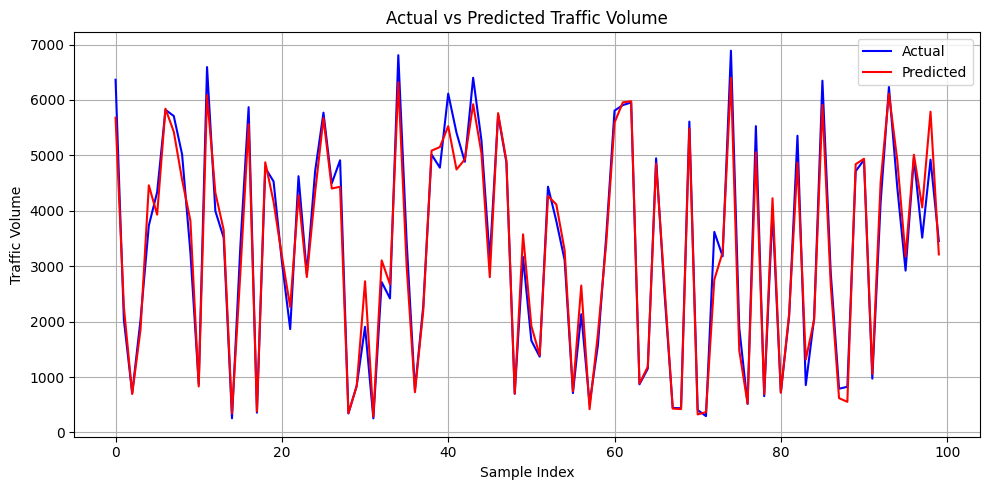

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:100], label="Actual", color='blue')
plt.plot(y_pred[:100], label="Predicted", color='red')
plt.title("Actual vs Predicted Traffic Volume")
plt.xlabel("Sample Index")
plt.ylabel("Traffic Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [51]:
import joblib

joblib.dump(model, "../output/xgb_model.pkl")
joblib.dump(scaler, "../output/scaler.pkl")



['../output/scaler.pkl']

In [ ]:
# train_model.py (or in Jupyter Notebook)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load data
df = pd.read_csv("../data/traffic_volume.csv")

# Handle missing values
df['temp'] = df['temp'].fillna(df['temp'].median())
df['rain'] = df['rain'].fillna(0)
df['snow'] = df['snow'].fillna(0)

# Combine date and time
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['Time'], format='%d-%m-%Y %H:%M:%S', errors='coerce')
df.dropna(subset=['datetime'], inplace=True)

# Extract features
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month

# Select final features
X = df[['temp', 'rain', 'snow', 'hour', 'dayofweek', 'month']]
y = df['traffic_volume']

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
model = XGBRegressor()
model.fit(X_train_scaled, y_train)

# Evaluation
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("✅ Model Evaluation")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

# Save model and scaler
joblib.dump(model, "../output/xgb_model.pkl")
joblib.dump(scaler, "../output/scaler.pkl")


FileNotFoundError: [Errno 2] No such file or directory: '../data/traffic volume.csv'